In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from func.extract_bispectrum import get_bi_spectrum,polycoherence
from scipy import signal
from torchsummary import summary
from func.attention import CABlock,SEBlock,CBAM
import pywt
import torch.fft
from func.MFCC import calcMFCC
from func.KANConv import KAN_Convolutional_Layer
# from func.MHDNET_1 import CombinedModel
# 检查GPU

import matplotlib.pyplot as plt
plt.style.use('dark_background')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import numpy as np
import os
#from model.model_4_categories import build_model
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
from func.extract_bispectrum import get_bi_spectrum


def cal_acc(label,prediction):
    num=0
    N = len(label)
    for i in range(len(label)):
        pred = np.argmax(prediction[i])
        if label[i]==pred:
            num+=1
    return num/N
def cal_acc_1(label,prediction):
    num=0
    N = len(label)
    for i in range(len(label)):
        pred = prediction[i]
        if label[i]==pred:
            num+=1
    return num/N

def shuffle_data_label(data, label):
    state = np.random.get_state()
    np.random.shuffle(data)
    np.random.set_state(state)
    np.random.shuffle(label)
    return data,label
def shuffle_two_data_label(train_data,train_label,test_data,test_label):
    state = np.random.get_state()
    np.random.shuffle(train_data)
    np.random.set_state(state)
    np.random.shuffle(train_label)
    np.random.set_state(state)
    np.random.shuffle(test_data)
    np.random.set_state(state)
    np.random.shuffle(test_label)
    
    return train_data,train_label,test_data,test_label

def generate_label(num=200):
    label = []
    for j in range(5):
        for i in range(num):
            label.append(j)
    return np.array(label)
def get_all_filenames(file_dir):
    #all_files = print("    ")
    all_files = [file for file in os.listdir(file_dir)]
    # print(all_files)
    return all_files
def load_hardsound(file_folder, class_list):
    for class_name in len(class_list):
        path = os.path.join(file_folder,class_name)
        all_files = get_all_filenames(path)
# 定义小波去噪函数
def wavelet_denoise(signal, wavelet='db1', level=1):
    # 小波分解
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    
    # 设置阈值（可以根据需求调整阈值）
    threshold = np.median(np.abs(coeffs[-level])) / 0.6745
    
    # 对高频分量应用软阈值去噪
    denoised_coeffs = [pywt.threshold(c, threshold, mode='soft') if i > 0 else c for i, c in enumerate(coeffs)]
    
    # 重构信号
    denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    return denoised_signal
# def wavelet_denoise(signal, wavelet='db2', level=5, threshold_ratio=0.15):
#     """
#     改进的小波去噪函数（含可视化）
#     参数：
#         signal: 输入信号
#         wavelet: 小波类型（默认'db2'）
#         level: 分解层数（默认5层）
#         threshold_ratio: 阈值比例（默认25%）
#     返回：
#         denoised_signal: 去噪后的信号
#         coeffs_plot_data: 各层分量的绘图数据（用于自定义绘图）
#     """
#     # 1. 小波分解
#     coeffs = pywt.wavedec(signal, wavelet, level=level)
    
#     # 2. 对除近似层外的所有细节层进行软阈值处理
#     denoised_coeffs = [coeffs[0]]  # 保留近似层aN（N=level）
#     for i in range(1, len(coeffs)):
#         detail_coeff = coeffs[i]
#         threshold = 0.15 * np.max(np.abs(coeffs[i])) if i <= 3 else 0.25 * np.max(np.abs(coeffs[i]))
#         denoised_coeffs.append(pywt.threshold(detail_coeff, threshold, mode='soft'))
    
#     # 3. 重构信号
#     denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
    
#     # 4. 准备绘图数据（时间轴对齐）
#     plot_data = {
#         'original_signal': signal,
#         'denoised_signal': denoised_signal,
#         'coeffs': {
#             f'a{level}': coeffs[0],  # 近似层
#             **{f'd{i}': coeffs[level-i+1] for i in range(level, 0, -1)}  # 细节层（d5到d1）
#         },
#         'denoised_coeffs': {
#             f'a{level}': denoised_coeffs[0],
#             **{f'd{i}': denoised_coeffs[level-i+1] for i in range(level, 0, -1)}
#         }
#     }
    
#     return denoised_signal



# 带通滤波
def band_pass_filter(original_signal, order, fc1,fc2, fs):
    b, a = signal.butter(N=order, Wn=[2*fc1/fs,2*fc2/fs], btype='bandpass') # 采用的是带通 b，a: IIR滤波器的分子（b）和分母（a）多项式系数向量
    new_signal = signal.lfilter(b, a, original_signal)
    return new_signal
# 转成MFCC
def get_mfcc(sigs,fs):
    shape = 256
    dataset = np.zeros((1,1,shape,shape))
    for sig in sigs:
        mfcc_features = calcMFCC(sig,fs,high_freq=400, filters_num=shape)
        # mfcc_features= calcMFCC(
        #     sig, 
        #     fs,          # 降采样至1 kHz
        #     win_length=0.08,           # 80 ms窗长
        #     win_step=0.04,             # 40 ms重叠
        #     filters_num=256,            # 低频聚焦
        #     high_freq=400,             # 限制高频
        #     pre_emphasis_coeff=0.7,    # 抑制高频噪声
        #     cep_lifter=35              # 强噪声抑制
        # )
        # 当前 mfcc_features.shape = (260, 26)，我们需要将其填充或裁剪为 (256, 256)
        num_frames, num_features = mfcc_features.shape
        # 1. 裁剪或填充 MFCC 特征图到 256x256
        target_size = shape
        
        # 如果帧数大于 256，裁剪；如果小于 256，填充
        if num_frames > target_size:
            mfcc_features = mfcc_features[:target_size, :]
        elif num_frames < target_size:
            mfcc_features = np.pad(mfcc_features, ((0, target_size - num_frames), (0, 0)), mode='constant')
        
        # # 如果特征数大于 256，裁剪；如果小于 256，填充
        # if num_features > target_size:
        #     mfcc_features = mfcc_features[:, :target_size]
        # elif num_features < target_size:
        #     mfcc_features = np.pad(mfcc_features, ((0, 0), (0, target_size - num_features)), mode='constant')
        
        # 2. 调整维度为 (1, 1, 256, 256)
        #mfcc_features = np.expand_dims(mfcc_features, axis=0)  # 增加批次维度
        mfcc_features = np.expand_dims(mfcc_features, axis=0)  # 增加通道维度
        #print(f"mfcc_features={mfcc_features.shape}")
        mfcc_features = 255 * (mfcc_features - np.min(mfcc_features)) / (np.max(mfcc_features) - np.min(mfcc_features))
        dataset = np.vstack((dataset, np.array([mfcc_features])))
    dataset = np.delete(dataset, 0, 0)
    return dataset
#针对切割后的数据
def get_bi_spectrum_1(sigs):
    
    dataset = np.zeros((1,1,256,256))
    for sig in sigs:
        #print(len(sig))
        freq1, freq2, bi_spectrum = polycoherence(sig,nfft=1024, fs = 1000, norm=None,noverlap = 20, nperseg=256)
        bi_spectrum = np.array(abs(bi_spectrum))  # calculate bi_spectrum
        bi_spectrum = bi_spectrum.reshape((1,256, 256))
        #这行代码的作用是对 bi_spectrum 进行归一化处理，使其值范围映射到 0 到 255 之间。具体步骤如下
        bi_spectrum = 255 * (bi_spectrum - np.min(bi_spectrum)) / (np.max(bi_spectrum) - np.min(bi_spectrum)) 
        dataset = np.vstack((dataset, np.array([bi_spectrum])))  # concat the dataset 是 NumPy 中用于按垂直方向（行）堆叠数组的函数
        #index+=1
            #print(class_nam,'num:',index)
        # remove the first one of the dataset, due to initialization
    dataset = np.delete(dataset, 0, 0)
    return dataset

In [3]:
import os
import librosa
import numpy as np

In [4]:
file_folder = '/home/qziedu/pcg/DATA/database_five_categories'
class_name = ['AS', 'MR', 'MS', 'MVP','N']

In [5]:
def segmentation(sig,sr,i,segment_duration=1):
    CutSegment = int(sr*segment_duration)
    hop_samples = CutSegment//2
    segments =[]
    start = 0
    #print(f"len(sig)={len(sig)}")
    while start+CutSegment <= len(sig):
        segments.append(sig[start:start+CutSegment])
        start += hop_samples
    #print(f"np.array(segments).shape={np.array(segments).shape}")
    return segments

In [6]:
# 生成标签
def generate_label_lstm(num=200,i=0):
    label = []
    for j in range(num):
        label.append(i)
    return np.array(label)

In [7]:
#处理1维度信息
all_files=[]
#segments = np.empty((0, 1500))
all_segment_sound = []

train_x ,train_y = [],[]
test_x, test_y= [],[]
def get_all_filenames(file_dir):
    #all_files = print("    ")
    all_files = [file for file in os.listdir(file_dir)]
    # print(all_files)
    return all_files
#加载数据 并且切割成1S每一段
def load_hardsound(file_folder, class_list,data_num=200):
    
    for index,class_name in enumerate(class_list):
        num = 0
        labels = []
        path = os.path.join(file_folder,class_name) # 获取5个文件夹路径
        print(path)
        all_files=get_all_filenames(path)    # 获取全部文件的文件名
        segments = np.empty((0, 2000))
        for name in all_files[:data_num]: # 遍历第一个文件200个音频
            audio_seg = []
            file_path = os.path.join(path, name) # 获取文件文件路径
            #file_path = 'D:\\notebook\\file\\pcg\\DATA\\database_four_categories\\AS\\New_AS_002.wav'
            #print(file_path)
            sig, sr = librosa.load(file_path, sr=2000) # load heart sound data
            sig = sig*0.5
            #print(f"范围: [{sig.min()}, {sig.max()}]") 
            #print(sig)
            audio_seg = segmentation(sig,sr,index)
            #print(f"audio_seg={audio_seg}")
            #print(np.array(audio_seg).shape)
            if(len(audio_seg)!=0):
                num +=len(audio_seg)
                denoised_signal = band_pass_filter(audio_seg, 2, 25,400, sr)
                #down_sample_audio_data = samplerate.resample(audio_seg_filter.T, 1000 / sr, converter_type='sinc_best').T
                #denoised_signal= wavelet_denoise(audio_seg_filter, wavelet='db4', level=4)
                denoised_signal = denoised_signal / np.max(np.abs(denoised_signal))
                #denoised_signal =-denoised_signal
                ##print(f"去噪后范围: [{denoised_signal.min()}, {denoised_signal.max()}]") 
                #down_sample_audio_data = down_sample_audio_data / np.max(np.abs(down_sample_audio_data))
                segments = np.concatenate((segments,denoised_signal))
            #segments.append(segmentation(sig,sr)) # 切成一段2s片段
            #print("______________")
#             print(np.array(a).shape)
            #print(sig.shape)
            #print(sr)
        print(f"num={num}")
        for label in range(len(segments)):
            labels.append(index)
        split_idx = int(len(segments)*0.8)
        train_x.append(segments[: split_idx])
        test_x.append(segments[split_idx:])
        #print(labels)
        train_y.append(labels[:split_idx])
        test_y.append(labels[split_idx:])
        all_segment_sound.append(segments)
        #print(segments.shape)
load_hardsound(file_folder,class_name)
train_x_1 = np.vstack(train_x)
test_x_1 = np.vstack(test_x)
train_y_1 = np.concatenate(train_y)
test_y_1 = np.concatenate(test_y)

/home/qziedu/pcg/DATA/database_five_categories/AS
num=809
/home/qziedu/pcg/DATA/database_five_categories/MR
num=609
/home/qziedu/pcg/DATA/database_five_categories/MS
num=646
/home/qziedu/pcg/DATA/database_five_categories/MVP
num=716
/home/qziedu/pcg/DATA/database_five_categories/N
num=688


In [8]:
# 打乱训练集和测试集
train_x_1,train_y,test_x_1,test_y=shuffle_two_data_label(train_x_1,train_y_1,test_x_1,test_y_1)
print(train_x_1.shape)
print(test_x_1.shape)
print(np.array(train_y).shape)
print(np.array(test_y).shape)

(2772, 2000)
(696, 2000)
(2772,)
(696,)


## 采用gpu训练

In [9]:
# if __name__ == '__main__':
np.random.seed(0)
#一维数据转成网络输入格式

#train_x_lstm = train_x_1.reshape(train_x_1.shape[0],train_x_1.shape[1],1)
#test_x_lstm = test_x_1.reshape(test_x_1.shape[0],test_x_1.shape[1],1)
# 转成2维形式
train_x_mfcc = get_mfcc(train_x_1,2000)
test_x_mfcc = get_mfcc(test_x_1,2000)

np.savez_compressed("/home/qziedu/pcg/train_data/data_3/train/train_data_6.npz", features=train_x_mfcc, labels=train_y)
np.savez_compressed("/home/qziedu/pcg/train_data/data_3/test/test_data_6.npz", features=test_x_mfcc, labels=test_y)

print(train_x_lstm.shape)
#train_x_lstm = torch.tensor(train_x_lstm, dtype=torch.float32).to(device)
#train_x_cnn = torch.tensor(train_x_cnn, dtype=torch.float32).to(device)
train_x_mfcc= torch.tensor(train_x_mfcc, dtype=torch.float32).to(device)
train_y = torch.tensor(train_y, dtype=torch.long).to(device)

#test_x_lstm = torch.tensor(test_x_lstm, dtype=torch.float32).to(device)
#test_x_cnn = torch.tensor(test_x_cnn, dtype=torch.float32).to(device)
test_x_mfcc= torch.tensor(test_x_mfcc, dtype=torch.float32).to(device)
test_y = torch.tensor(test_y, dtype=torch.long).to(device)
print(train_x_lstm.shape)
#print(train_x_cnn.shape)
print(train_x_mfcc.shape)   

(2772, 2000, 1)
torch.Size([2772, 2000, 1])
torch.Size([2772, 1, 256, 256])


In [1]:
# 加载数据集
import numpy as np
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_data = np.load('/home/qziedu/pcg/train_data/data_3/train/train_data.npz')
test_data = np.load('/home/qziedu/pcg/train_data/data_3/test/test_data.npz')
train_x = train_data['features']
train_y = train_data['labels']
test_x = test_data['features']
test_y = test_data['labels']

train_x = torch.tensor(train_x,dtype=torch.float32)
train_y = torch.tensor(train_y,dtype=torch.long)
test_x = torch.tensor(test_x,dtype=torch.float32)
test_y = torch.tensor(test_y,dtype=torch.long)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

torch.Size([2772, 1, 256, 256])
torch.Size([2772])
torch.Size([696, 1, 256, 256])
torch.Size([696])


In [2]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from func.extract_bispectrum import get_bi_spectrum,polycoherence
# from scipy import signal
# from torchsummary import summary
# from func.attention import CABlock,SEBlock,CBAM
# import pywt
# import torch.fft
# from func.MFCC import calcMFCC
# from func.KANConv import KAN_Convolutional_Layer
# # 检查GPU

# print(device)
# # Transformer层
# import torch
# import torch.nn as nn
# class CNN(nn.Module):
#     def __init__(self, stride=1):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, stride=stride, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout(0.2)
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Dropout(0.2)
#         )
#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(128 * 32 * 32, 128),  # 假设输入是128x128
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Linear(128, 128),
#             nn.ReLU(),
#             nn.Linear(128, 5)  # 二分类输出
#         )
    
#     def forward(self, x):
#         x = self.conv1(x) #
#         x = self.conv2(x)
#         x = self.conv3(x)
#         x = self.fc(x)
#         return x


# class CombinedModel(nn.Module):
#     def __init__(self):
#         super(CombinedModel, self).__init__()

#         self.cnn = CNN()

#     def forward(self,x_lstm,x_mfcc,x_cnn):
#         cnn_output = self.cnn(x_mfcc)
        
#         return cnn_output

In [3]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from func.extract_bispectrum import get_bi_spectrum,polycoherence
# from scipy import signal
# from torchsummary import summary
# from func.attention import CABlock,SEBlock,CBAM
# import pywt
# import torch.fft
# from func.MFCC import calcMFCC
# from func.KANConv import KAN_Convolutional_Layer
# # 检查GPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# # Transformer层
# import torch
# import torch.nn as nn

# from transformers import AutoConfig, AutoModel

# class TransformerLayer(nn.Module):
#     def __init__(
#         self, 
#         embed_dim=64, 
#         num_heads=4, 
#         ff_dim=64, 
#         max_seq_len=1600, 
#         dropout_rate=0.1,
#         #sparse_attention=True,
#         #block_size=64,
#         #num_random_blocks=3
#     ):
#         super().__init__()
        
#         # 1. 可学习位置编码
#         self.positional_embedding = nn.Parameter(torch.randn(int(max_seq_len), int(embed_dim)))
        
#         self.attention = nn.MultiheadAttention(
#                 embed_dim=embed_dim, 
#                 num_heads=num_heads, 
#                 dropout=dropout_rate
#             )
        
#         # 3. Pre-LN 结构所需的层归一化
#         self.norm1 = nn.LayerNorm(embed_dim)
#         self.norm2 = nn.LayerNorm(embed_dim)
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.dropout2 = nn.Dropout(dropout_rate)
        
#         # 4. 前馈网络
#         self.ffn = nn.Sequential(
#             nn.Linear(embed_dim, ff_dim),
#             nn.GELU(),  # 更平滑的激活函数
#             nn.Linear(ff_dim, embed_dim)
#         )

#     def forward(self, x):
#         # x 形状: [seq_len, batch_size, embed_dim] (Transformer 标准输入格式)
        
#         # 添加位置编码
#         seq_len = x.size(0)
#         x = x + self.positional_embedding[:seq_len, :].unsqueeze(1)  # [seq_len, 1, embed_dim]
        
#         # Pre-LN 结构
#         # 自注意力分支
#         x_norm = self.norm1(x)

#         attn_output, _ = self.attention(x_norm, x_norm, x_norm)
        
#         x = x + self.dropout1(attn_output)
        
#         # 前馈分支
#         x_norm = self.norm2(x)
#         ffn_output = self.ffn(x_norm)
#         x = x + self.dropout2(ffn_output)
        
#         return x

# # Conv-LSTM模型
# class ConvLSTMModel(nn.Module):
#     def __init__(self, embed_dim=64, num_heads=4, ff_dim=64, dropout_rate=0.1):
#         super(ConvLSTMModel, self).__init__()
        
#         self.lstm1 = nn.LSTM(input_size=1, hidden_size=embed_dim, batch_first=True,dropout=dropout_rate)
#         self.transformer = TransformerLayer(embed_dim=embed_dim, num_heads = num_heads, ff_dim=ff_dim, dropout_rate = dropout_rate)
#         self.lstm2 = nn.LSTM(input_size=embed_dim, hidden_size=64, batch_first=True,dropout=dropout_rate)
#         self.fc = nn.Linear(64, 5)

#     def forward(self, x): # x = (16,1600,1)
#         x, _ = self.lstm1(x)
#         x = x.permute(1, 0, 2)  # Transformer要求seq_len在前
#         x = self.transformer(x)
#         x = x.permute(1, 0, 2) #恢复为[batch_size, seq_len, input_dim]
#         x, _ = self.lstm2(x)
#         #x = x.mean(dim=1)
#         x = x[:, -1, :]  # 取最后一个时间步
#         #return x
#         return F.softmax(self.fc(x), dim=-1)

# class CNNModel_1(nn.Module):
#     def __init__(self, stride=1):
#         super(CNNModel_1, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         # self.fc = nn.Sequential(
#         #     nn.Flatten(),
#         #     nn.Linear(64 * 25 * 3, 128),  # 假设输入是128x128
#         #     nn.ReLU(),
#         #     nn.Dropout(0.2),
#         #     nn.Linear(128, 64),
#         #     nn.ReLU(),
#         #     nn.Linear(64, 64),
#         #     nn.ReLU(),
#         #     nn.Linear(64, 5)  # 二分类输出
#         # )
    
#     def forward(self, x,lstm_output):
#         x = self.conv1(x) #128
#         x = self.conv2(x)#64
#         x = self.conv3(x)#32
#         x = self.conv4(x)#32
#         #x = self.fc(x)
#         return x
# class CNNModel_2(nn.Module):
#     def __init__(self,embed_dim=64, num_heads=4, ff_dim=64, dropout_rate=0.1):
#         super(CNNModel_2, self).__init__()
#         self.conv5 = nn.Conv2d(1,64,kernel_size=5,padding=2)
#         self.bn5 = nn.BatchNorm2d(64)
#         self.conv1 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 16, kernel_size=5, padding=2)
#         self.bn2 = nn.BatchNorm2d(16)
#         self.conv3 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
#         self.bn3 = nn.BatchNorm2d(8)
#         self.conv4 = nn.Conv2d(8, 16, kernel_size=5, padding=2)       
#         self.bn4 = nn.BatchNorm2d(16)

#         # self.conv6 = nn.Conv2d(16, 32, kernel_size=3, padding=2)       
#         # self.bn6 = nn.BatchNorm2d(32)
        
#         # self.conv7 = nn.Conv2d(8, 16, kernel_size=3, padding=1)       
#         # self.bn7 = nn.BatchNorm2d(16)
#         # self.conv8 = nn.Conv2d(8, 16, kernel_size=5, padding=1)       
#         # self.bn8 = nn.BatchNorm2d(16)
        
#          # Transformer 层
#         #self.transformer = TransformerLayer(embed_dim, num_heads, ff_dim, dropout_rate)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.flatten = nn.Flatten()

#     def forward(self, x,lstm_features):
#         x = self.pool(F.relu(self.bn5(self.conv5(x))))#128
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         # lstm_features = lstm_features.unsqueeze(2).unsqueeze(3).expand(-1,-1,x.size(2),x.size(3))
#         # x = torch.cat([x,lstm_features],dim=1)
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))       
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         #x = self.pool(F.relu(self.bn4(self.conv4(x))))
#         x = F.relu(self.bn4(self.conv4(x)))
#         # x = self.gap(x)
#         return x

# # 组合模型
# class CombinedModel(nn.Module):
#     def __init__(self,attensionChannel = 144):
#         super(CombinedModel, self).__init__()
#         self.conv_lstm_model = ConvLSTMModel()
#         self.cnn_model_1 = CNNModel_1()
#         self.cnn_model_2 = CNNModel_2()       
#         self.lstm = nn.LSTM(input_size=attensionChannel, hidden_size=64, batch_first=True)
#         #self.lstm_1 = nn.LSTM(input_size=128, hidden_size=32, batch_first=True)        
#         #self.fc = nn.Linear(32*32, 5)
#         # self.fc = nn.Linear(128 , 5)
#         self.flatten = nn.Flatten()
#         self.ca = CABlock(attensionChannel)
#         self.cbam = CBAM(attensionChannel)
#         self.se = SEBlock(attensionChannel)
#         self.gavg = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(144, 5)) # 假设输入是128x128 64*16*16
#         # )# 二分类输出
#     def forward(self, x_lstm,x_cnn,x_mfcc):
#         lstm_output = self.conv_lstm_model(x_lstm)
#         cnn_output_1 = self.cnn_model_1(x_mfcc,lstm_output )
#         cnn_output_2 = self.cnn_model_2(x_mfcc,lstm_output )
#         cnn_outputs = torch.concat([cnn_output_1,cnn_output_2],dim=1)
        
#         #注意力机制
#         cnn_outputs_cbam  = self.cbam( cnn_outputs )
#         #cnn_outputs = torch.concat([cnn_outputs_ca ,cnn_outputs_cbam],dim=1)
#         cnn_outputs = cnn_outputs_cbam 
        
#         cnn_outputs =  self.gavg(cnn_outputs)
#         # batch_size, channels, height, width = cnn_outputs.size()
      
#         # cnn_outputs= cnn_outputs.view(batch_size, height * width, channels)
        
#         # #LSTM部分
#         # cnn_outputs, _ = self.lstm(cnn_outputs)

#         # # cnn_outputs, _ = self.lstm_1(cnn_outputs)
        
#         # #x,_ = self.lstm_2(x)
#         # #取LSTM最后一个时间步的输出
#         # cnn_outputs = cnn_outputs[:, -1, :]  # (batch_size, lstm_hidden_size)
#         #print(f"cnn_outputs.shape={cnn_outputs.shape}")
#         #分类
#         cnn_outputs = self.fc(cnn_outputs)
#         # #cnn_outputs = self.fc(cnn_outputs )
#         combined_output = cnn_outputs  # 简单相加作为融合方法+lstm_output
#         return combined_output
#         #return F.softmax(combined_output, dim=-1)

In [4]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.nn.functional as F
# from func.extract_bispectrum import get_bi_spectrum,polycoherence
# from scipy import signal
# from torchsummary import summary
# from func.attention import CABlock,SEBlock,CBAM
# import pywt
# import torch.fft
# from func.MFCC import calcMFCC
# from func.KANConv import KAN_Convolutional_Layer
# # 检查GPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# # Transformer层
# import torch
# import torch.nn as nn

# from transformers import AutoConfig, AutoModel

# class TransformerLayer(nn.Module):
#     def __init__(
#         self, 
#         embed_dim=64, 
#         num_heads=4, 
#         ff_dim=64, 
#         max_seq_len=1600, 
#         dropout_rate=0.1,
#         #sparse_attention=True,
#         #block_size=64,
#         #num_random_blocks=3
#     ):
#         super().__init__()
        
#         # 1. 可学习位置编码
#         self.positional_embedding = nn.Parameter(torch.randn(int(max_seq_len), int(embed_dim)))
        
#         self.attention = nn.MultiheadAttention(
#                 embed_dim=embed_dim, 
#                 num_heads=num_heads, 
#                 dropout=dropout_rate
#             )
        
#         # 3. Pre-LN 结构所需的层归一化
#         self.norm1 = nn.LayerNorm(embed_dim)
#         self.norm2 = nn.LayerNorm(embed_dim)
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.dropout2 = nn.Dropout(dropout_rate)
        
#         # 4. 前馈网络
#         self.ffn = nn.Sequential(
#             nn.Linear(embed_dim, ff_dim),
#             nn.GELU(),  # 更平滑的激活函数
#             nn.Linear(ff_dim, embed_dim)
#         )

#     def forward(self, x):
#         # x 形状: [seq_len, batch_size, embed_dim] (Transformer 标准输入格式)
        
#         # 添加位置编码
#         seq_len = x.size(0)
#         x = x + self.positional_embedding[:seq_len, :].unsqueeze(1)  # [seq_len, 1, embed_dim]
        
#         # Pre-LN 结构
#         # 自注意力分支
#         x_norm = self.norm1(x)

#         attn_output, _ = self.attention(x_norm, x_norm, x_norm)
        
#         x = x + self.dropout1(attn_output)
        
#         # 前馈分支
#         x_norm = self.norm2(x)
#         ffn_output = self.ffn(x_norm)
#         x = x + self.dropout2(ffn_output)
        
#         return x

# # Conv-LSTM模型
# class ConvLSTMModel(nn.Module):
#     def __init__(self, embed_dim=64, num_heads=4, ff_dim=64, dropout_rate=0.1):
#         super(ConvLSTMModel, self).__init__()
        
#         self.lstm1 = nn.LSTM(input_size=1, hidden_size=embed_dim, batch_first=True,dropout=dropout_rate)
#         self.transformer = TransformerLayer(embed_dim=embed_dim, num_heads = num_heads, ff_dim=ff_dim, dropout_rate = dropout_rate)
#         self.lstm2 = nn.LSTM(input_size=embed_dim, hidden_size=64, batch_first=True,dropout=dropout_rate)
#         self.fc = nn.Linear(64, 5)

#     def forward(self, x): # x = (16,1600,1)
#         x, _ = self.lstm1(x)
#         x = x.permute(1, 0, 2)  # Transformer要求seq_len在前
#         x = self.transformer(x)
#         x = x.permute(1, 0, 2) #恢复为[batch_size, seq_len, input_dim]
#         x, _ = self.lstm2(x)
#         #x = x.mean(dim=1)
#         x = x[:, -1, :]  # 取最后一个时间步
#         #return x
#         return F.softmax(self.fc(x), dim=-1)

# class CNNModel_1(nn.Module):
#     def __init__(self, stride=1):
#         super(CNNModel_1, self).__init__()
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )
#         self.conv3 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         self.conv4 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         # self.fc = nn.Sequential(
#         #     nn.Flatten(),
#         #     nn.Linear(64 * 25 * 3, 128),  # 假设输入是128x128
#         #     nn.ReLU(),
#         #     nn.Dropout(0.2),
#         #     nn.Linear(128, 64),
#         #     nn.ReLU(),
#         #     nn.Linear(64, 64),
#         #     nn.ReLU(),
#         #     nn.Linear(64, 5)  # 二分类输出
#         # )
    
#     def forward(self, x,lstm_output):
#         x = self.conv1(x) #128
#         x = self.conv2(x)#64
#         x = self.conv3(x)#32
#         x = self.conv4(x)#32
#         #x = self.fc(x)
#         return x
# class CNNModel_2(nn.Module):
#     def __init__(self,embed_dim=64, num_heads=4, ff_dim=64, dropout_rate=0.1):
#         super(CNNModel_2, self).__init__()
#         self.conv5 = nn.Conv2d(1,64,kernel_size=5,padding=2)
#         self.bn5 = nn.BatchNorm2d(64)
#         self.conv1 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
#         self.bn1 = nn.BatchNorm2d(32)
#         #self.ca = caBlock(32)
#         self.conv2 = nn.Conv2d(32, 16, kernel_size=5, padding=2)
#         self.bn2 = nn.BatchNorm2d(16)
#         self.conv3 = nn.Conv2d(16, 8, kernel_size=5, padding=2)
#         self.bn3 = nn.BatchNorm2d(8)
#         self.conv4 = nn.Conv2d(8, 16, kernel_size=5, padding=2)       
#         self.bn4 = nn.BatchNorm2d(16)

#         # self.conv6 = nn.Conv2d(16, 32, kernel_size=3, padding=2)       
#         # self.bn6 = nn.BatchNorm2d(32)
        
#         # self.conv7 = nn.Conv2d(8, 16, kernel_size=3, padding=1)       
#         # self.bn7 = nn.BatchNorm2d(16)
#         # self.conv8 = nn.Conv2d(8, 16, kernel_size=5, padding=1)       
#         # self.bn8 = nn.BatchNorm2d(16)
        
#          # Transformer 层
#         #self.transformer = TransformerLayer(embed_dim, num_heads, ff_dim, dropout_rate)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.flatten = nn.Flatten()

#     def forward(self, x,lstm_features):
#         x = self.pool(F.relu(self.bn5(self.conv5(x))))#128
#         x = self.pool(F.relu(self.bn1(self.conv1(x))))
#         #x = self.ca(x)
#         # lstm_features = lstm_features.unsqueeze(2).unsqueeze(3).expand(-1,-1,x.size(2),x.size(3))
#         # x = torch.cat([x,lstm_features],dim=1)
#         x = self.pool(F.relu(self.bn2(self.conv2(x))))       
#         x = self.pool(F.relu(self.bn3(self.conv3(x))))
#         #x = self.pool(F.relu(self.bn4(self.conv4(x))))
#         x = F.relu(self.bn4(self.conv4(x)))
#         # x = self.gap(x)
#         return x

# # 组合模型
# class CombinedModel(nn.Module):
#     def __init__(self,attensionChannel = 144):
#         super(CombinedModel, self).__init__()
#         self.conv_lstm_model = ConvLSTMModel()
#         self.cnn_model_1 = CNNModel_1()
#         self.cnn_model_2 = CNNModel_2()       
#         self.lstm = nn.LSTM(input_size=attensionChannel, hidden_size=64, batch_first=True)
#         self.transformer = TransformerLayer(embed_dim=embed_dim, num_heads = num_heads, ff_dim=ff_dim, dropout_rate = dropout_rate)
#         self.lstm2 = nn.LSTM(input_size=embed_dim, hidden_size=64, batch_first=True,dropout=dropout_rate)
#         self.fc = nn.Linear(64, 5)
#         #self.lstm_1 = nn.LSTM(input_size=128, hidden_size=32, batch_first=True)        
#         #self.fc = nn.Linear(32*32, 5)
#         # self.fc = nn.Linear(128 , 5)
#         self.flatten = nn.Flatten()
#         self.ca = CABlock(attensionChannel)
#         self.cbam = CBAM(attensionChannel)
#         self.se = SEBlock(attensionChannel)
#         self.gavg = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(144, 5)) # 假设输入是128x128 64*16*16
#         # )# 二分类输出
#     def forward(self, x_lstm,x_cnn,x_mfcc):
#         lstm_output = self.conv_lstm_model(x_lstm)
#         cnn_output_1 = self.cnn_model_1(x_mfcc,lstm_output )
#         cnn_output_2 = self.cnn_model_2(x_mfcc,lstm_output )
#         cnn_outputs = torch.concat([cnn_output_1,cnn_output_2],dim=1)
        
#         #注意力机制
#         cnn_outputs_cbam  = self.cbam( cnn_outputs )
#         #cnn_outputs = torch.concat([cnn_outputs_ca ,cnn_outputs_cbam],dim=1)
#         cnn_outputs = cnn_outputs_cbam 
        
#         # cnn_outputs =  self.gavg(cnn_outputs)
#         batch_size, channels, height, width = cnn_outputs.size()
      
#         cnn_outputs= cnn_outputs.view(batch_size, height * width, channels)
        
#         # #LSTM部分
#         cnn_outputs, _ = self.lstm(cnn_outputs)
#         cnn_outputs = cnn_outputs.permute(1, 0, 2)  # Transformer要求seq_len在前
#         cnn_outputs = self.transformer(cnn_outputs)
#         cnn_outputs = cnn_outputs.permute(1, 0, 2) #恢复为[batch_size, seq_len, input_dim]
#         cnn_outputs, _ = self.lstm2(cnn_outputs)
#         #x = x.mean(dim=1)
#         x = x[:, -1, :]  # 取最后一个时间步
#         # # cnn_outputs, _ = self.lstm_1(cnn_outputs)
        
#         # #x,_ = self.lstm_2(x)
#         # #取LSTM最后一个时间步的输出
#         # cnn_outputs = cnn_outputs[:, -1, :]  # (batch_size, lstm_hidden_size)
#         #print(f"cnn_outputs.shape={cnn_outputs.shape}")
#         #分类
#         cnn_outputs = self.fc(cnn_outputs)
#         # #cnn_outputs = self.fc(cnn_outputs )
#         combined_output = cnn_outputs  # 简单相加作为融合方法+lstm_output
#         return combined_output
#         #return F.softmax(combined_output, dim=-1)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from func.trans import TransformerLayer
from func.attention import CABlock,SEBlock,CBAM
import torch.nn.functional as F
class CNNModel_1(nn.Module):
    def __init__(self, stride=1):
        super(CNNModel_1, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        #x = self.fc(x)
        return x
class CNNModel_2(nn.Module):
    def __init__(self,embed_dim=64, num_heads=4, ff_dim=64, dropout_rate=0.1):
        super(CNNModel_2, self).__init__()
        self.conv5 = nn.Conv2d(64,64,kernel_size=5,padding=2)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 16, kernel_size=3, padding=1)       
        self.bn4 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.pool(F.relu(self.bn5(self.conv5(x))))#128
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))       
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        return x
class CombinedModel(nn.Module):
    def __init__(self,attensionChannel = 128): #16
        super(CombinedModel, self).__init__()
        self.cnn_model_1 = CNNModel_1()
        self.cnn_model_2 = CNNModel_2() 
        self.cov_pool = nn.Sequential(
            nn.Conv2d(64,16,kernel_size=1,stride=2),
            nn.MaxPool2d(2, stride=2),# 32×32 → 16×16（浅层保留细节）
            nn.Conv2d(16,16,kernel_size=1,stride=2),
            nn.MaxPool2d(2, stride=2) # 32×32 → 16×16（浅层保留细节）
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
                nn.Flatten(),
                nn.Linear(16*2*2, 256),  
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 5)  # 
            )
    def forward(self, x_mfcc):
        cnn_output_1 = self.cnn_model_1(x_mfcc ) # (16,128,32,32 )

        cnn_output_1_1 = self.cov_pool(cnn_output_1)
        cnn_output_2 = self.cnn_model_2(cnn_output_1 )  #(32,16,2,2)
        #fused = torch.concat([cnn_output_1_1,cnn_output_2],dim=1)
        fused = cnn_output_1_1 + cnn_output_2 
        cnn_outputs =   fused
        cnn_outputs = self.fc(cnn_outputs)
        combined_output = cnn_outputs  
        return combined_output

In [6]:
from torchsummary import summary
# 超参数定义
num_epochs = 80
learning_rate = 0.001
batch_size = 32  
# 初始化模型并移至GPU
model = CombinedModel()
model.to(device)
# summary(model, input_size=[(1, 256, 256), (1, 256, 256), (1, 256, 256)])



CombinedModel(
  (cnn_model_1): CNNModel_1(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
    )
  )
  (cnn_model_2): CNNModel_2(
    (conv5): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (bn5): BatchNorm2d(64, eps=1e-05

In [7]:

class_weight = torch.tensor([1.03,1.03,1.03,1.03,1.0]).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
class FocalLoss(nn.Module): 
    def __init__(self, alpha=1, gamma=1.7,reduction='mean'): 
        super(FocalLoss, self).__init__() 
        self.alpha = alpha 
        self.gamma = gamma 
        self.reduction = reduction
    def forward(self, inputs, targets): 
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)  
        pt = torch.exp(-ce_loss) 
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss 
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

criterion = nn.CrossEntropyLoss()

In [8]:

import time
train_accuraces=[]
loss_list =[]
total_time=0
# 训练模型
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    
    correct_train =0
    total_train = 0
    for i in range(0, len(train_x), batch_size):
        # 获取当前批量数据
        x_mfcc_batch = train_x[i:i+batch_size]
        y_batch = train_y[i:i+batch_size]

        x_mfcc_batch = x_mfcc_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_mfcc_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        _,predicted = torch.max(outputs,1)
        correct_train += (predicted==y_batch).sum().item()
        total_train += y_batch.size(0)  # 获取当前的样本数并累计
    runTime = time.time()-start
    total_time += runTime
    train_accuracy = correct_train/ total_train
    train_accuraces.append(train_accuracy)
    loss_list.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f},runTime={runTime:.2f}')
#print(f"toal_time = {total_time}")



Epoch [1/80], Loss: 0.9294,runTime=1.93
Epoch [2/80], Loss: 0.4096,runTime=1.54
Epoch [3/80], Loss: 0.3111,runTime=1.56
Epoch [4/80], Loss: 0.0584,runTime=1.55
Epoch [5/80], Loss: 0.0651,runTime=1.54
Epoch [6/80], Loss: 0.0255,runTime=1.55
Epoch [7/80], Loss: 0.0408,runTime=1.55
Epoch [8/80], Loss: 0.0607,runTime=1.54
Epoch [9/80], Loss: 0.0755,runTime=1.54
Epoch [10/80], Loss: 0.0189,runTime=1.56
Epoch [11/80], Loss: 0.0078,runTime=1.56
Epoch [12/80], Loss: 0.0087,runTime=1.55
Epoch [13/80], Loss: 0.0046,runTime=1.55
Epoch [14/80], Loss: 0.0043,runTime=1.58
Epoch [15/80], Loss: 0.0157,runTime=1.55
Epoch [16/80], Loss: 0.0131,runTime=1.71
Epoch [17/80], Loss: 0.0159,runTime=1.57
Epoch [18/80], Loss: 0.0021,runTime=1.54
Epoch [19/80], Loss: 0.0033,runTime=1.57
Epoch [20/80], Loss: 0.0464,runTime=1.56
Epoch [21/80], Loss: 0.0073,runTime=1.54
Epoch [22/80], Loss: 0.0981,runTime=1.56
Epoch [23/80], Loss: 0.0019,runTime=1.55
Epoch [24/80], Loss: 0.0017,runTime=1.56
Epoch [25/80], Loss: 0.00

In [9]:
torch.save(model.state_dict(), '/home/qziedu/pcg/model/data_3/train4_pytorch-3-data0.8-0-5-7.pth')

In [10]:
# import time
# import torch
# import numpy as np
# from sklearn.metrics import confusion_matrix
# import matplotlib.pyplot as plt
# import seaborn as sns

# # 初始化记录容器
# train_accuracies = []
# val_accuracies = []  # 新增验证准确率记录
# loss_list = []
# total_time = 0

# # 训练模型
# for epoch in range(num_epochs):
#     # 训练阶段
#     epoch_start = time.time()
#     model.train()
    
#     correct_train = 0
#     total_train = 0
#     for i in range(0, len(train_x_lstm), batch_size):
#         # 数据准备（保持原样）
#         x_lstm_batch = train_x_lstm[i:i+batch_size].to(device)
#         x_mfcc_batch = train_x_mfcc[i:i+batch_size].to(device)
#         y_batch = train_y[i:i+batch_size].to(device)

#         # 前向传播+反向传播（保持原样）
#         optimizer.zero_grad()
#         outputs = model(x_lstm_batch, x_mfcc_batch, x_mfcc_batch)
#         loss = criterion(outputs, y_batch)
#         loss.backward()
#         optimizer.step()

#         # 统计训练准确率
#         _, predicted = torch.max(outputs, 1)
#         correct_train += (predicted == y_batch).sum().item()
#         total_train += y_batch.size(0)

#     # 记录训练指标
#     train_accuracy = correct_train / total_train
#     train_accuracies.append(train_accuracy)
#     loss_list.append(loss.item())
    
#     # 验证阶段（新增）
#     model.eval()
#     correct_val = 0
#     total_val = 0
#     predictions = []
#     true_labels = []
    
#     with torch.no_grad():
#         for i in range(0, len(test_x_lstm), batch_size):
#             # 验证数据准备
#             x_lstm_batch = test_x_lstm[i:i+batch_size].to(device)
#             x_mfcc_batch = test_x_mfcc[i:i+batch_size].to(device)
#             y_batch = test_y[i:i+batch_size].to(device)

#             # 验证推理
#             outputs = model(x_lstm_batch, x_mfcc_batch, x_mfcc_batch)
#             _, predicted = torch.max(outputs, 1)
            
#             # 统计验证准确率
#             correct_val += (predicted == y_batch).sum().item()
#             total_val += y_batch.size(0)
            
#             # 收集预测结果
#             predictions.extend(predicted.cpu().numpy())
#             true_labels.extend(y_batch.cpu().numpy())

#     # 记录验证指标
#     val_accuracy = correct_val / total_val
#     val_accuracies.append(val_accuracy)
    
#     # 计时统计
#     epoch_time = time.time() - epoch_start
#     total_time += epoch_time
    
#     # 打印epoch信息
#     print(f'Epoch [{epoch+1}/{num_epochs}], '
#           f'Loss: {loss.item():.4f}, '
#           f'Train Acc: {train_accuracy:.2%}, '
#           f'Val Acc: {val_accuracy:.2%}, '
#           f'Time: {epoch_time:.2f}s')

# # 最终验证（新增）
# print("\nFinal Evaluation:")
# final_predictions, final_true_labels, final_val_accuracy = evaluate_model(model)
# print(f"Final Validation Accuracy: {final_val_accuracy:.2%}")

# # 保存结果（保持原样）
# torch.save(model.state_dict(), 'model/train4_pytorch-3-data0.8-0-5-3.pth')
# np.save('result/result_4/pred-0', final_predictions)
# np.save('result/result_4/label-0', final_true_labels)
# acc = cal_acc_1(final_true_labels, final_predictions)
# print(f"Final Calculated Accuracy: {acc:.2%}")

## test集

In [11]:
# # 训练完成后可添加学习曲线绘制
# plt.figure(figsize=(10, 5))
# plt.plot(train_accuracies, label='Train Accuracy')
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

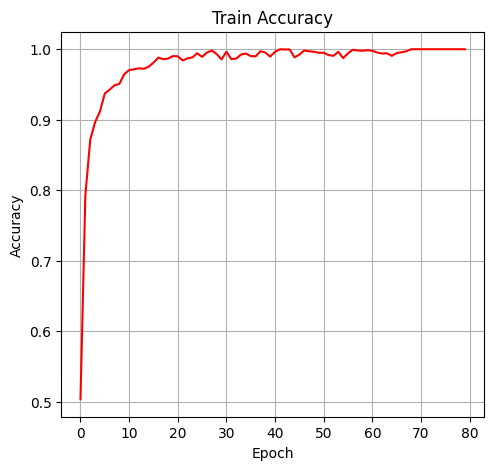

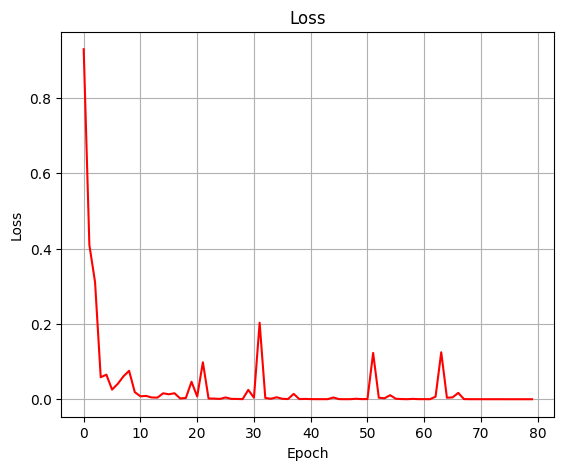

In [12]:
# 可视化

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_accuraces,label = "train Accuracy",color='red')
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()

plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(loss_list,label = "Train loss",color='red')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

    # plt.subplot(1,2,2)
    # plt.bar(["Validation Accuracy"],[val_accuracies],color='black')
    # plt.title("Val Accuracy")
    # plt.ylabel("Accuracy")
    # plt.ylim(0,1)
    # plt.grid(axis="y")
    # plt.tight_layout() 

In [13]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
 
# 模型推理代码
def evaluate_model(model):
    model.eval()  # 设置模型为评估模式
    predictions = []
    true_labels = []
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # 关闭梯度计算
        for i in range(0, len(test_x), batch_size):
            x_mfcc_batch = test_x[i:i+batch_size].to(device)
            y_batch = test_y[i:i+batch_size].to(device)

            # 获取预测结果
            outputs = model(x_mfcc_batch)
            _, predicted = torch.max(outputs, 1)  # 获取每行的最大值作为预测类别
            correct_val += (predicted==y_batch).sum().item()
            #print( correct_val)
            total_val += y_batch.size(0)
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(y_batch.cpu().numpy())
        val_accuracy = correct_val / total_val
    return np.array(predictions), np.array(true_labels),val_accuracy

# 调用evaluate_model函数获取预测值和真实标签
predictions, true_labels,val_accuracy = evaluate_model(model)
print(val_accuracy)
print(type(predictions))
# 确保predictions和test_y都在CPU上
# predictions = predictions.cpu()
# test_labels = test_y.cpu()
torch.save(model, 'model/model_4-0.pth')
np.save('result/result_4/pred-0',predictions)
np.save('result/result_4/label-0',true_labels)



0.992816091954023
<class 'numpy.ndarray'>


# 计算混淆矩阵

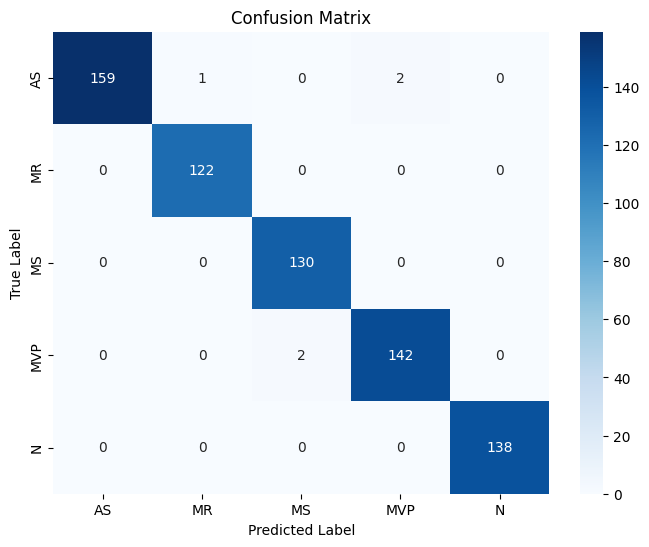

In [14]:
# 绘制混淆矩阵
def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# 假设类别标签为0到4
class_name = ['AS', 'MR', 'MS', 'MVP','N']
plot_confusion_matrix(true_labels, predictions, class_name)


# 计算召唤率

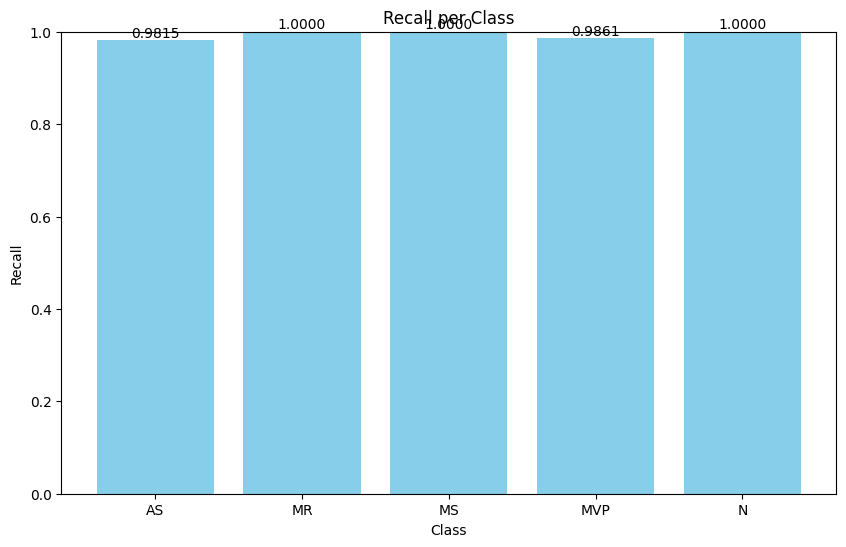

In [15]:
from sklearn.metrics import recall_score
# import matplotlib.pyplot as plt
# import numpy as np

# 假设true_labels和predictions已经计算得出
# 计算每个类别的召回率
class_recall = recall_score(true_labels, predictions, average=None)

# 绘制条形图
def plot_recall_bar(class_recall, class_names):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, class_recall, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Recall")
    plt.title("Recall per Class")

    # 在每个条形图顶部显示召回率值
    for bar, recall in zip(bars, class_recall):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{recall:.4f}", ha="center", va="bottom")
    
    plt.ylim(0, 1)  # 设置y轴范围
    plt.show()

# 假设类别标签为0到4
# class_names = ['AS', 'MR', 'MS', 'MVP','N']
plot_recall_bar(class_recall, class_name)


In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix

# 假设真实标签和预测标签
#y_true = np.array([0, 1, 2, 3, 4, 0, 1, 2, 3, 4])  # 真实标签
#y_pred = np.array([0, 1, 2, 3, 0, 0, 2, 2, 3, 4])  # 模型预测标签

# 生成混淆矩阵
conf_mat = confusion_matrix(true_labels,predictions)
print(conf_mat)
# 定义函数计算 accuracy, sensitivity, specificity
def calculate_metrics(conf_mat):
    n_classes = conf_mat.shape[0]  # 类别数量
    f1_scores = []
    total_samples = np.sum(conf_mat)
    class_samples = np.sum(conf_mat,axis=1)
    for i in range(n_classes):
        TP = conf_mat[i, i]
        FN = np.sum(conf_mat[i, :]) - TP
        FP = np.sum(conf_mat[:, i]) - TP
        TN = np.sum(conf_mat) - (TP + FN + FP)
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        sprecision = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1_score = 2*sensitivity*sprecision/(sprecision+sensitivity) if (sprecision+sensitivity) > 0 else 0
        f1_scores.append(f1_score)
        print(f"{class_name[i]}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Sensitivity: {sensitivity:.4f}")
        print(f"  Specificity: {specificity:.4f}")
        print(f"  f1_score: {f1_score:.4f}")
        print()
    #计算宏平均F1分数
    macro_f1 = np.mean(f1_scores)
    #计算加权平均F1分数
    weighted_f1 = np.sum([f1_scores[i]*class_samples[i] for i in range(n_classes)])/total_samples
    print(f"   macro_f1: { macro_f1:.4f}")
    print(f"  weighted_f1 : {weighted_f1 :.4f}")
# 计算每个类别的指标
calculate_metrics(conf_mat)
#计算总的准确值
total_tp = np.trace(conf_mat)# 计算对角元素之和
total_samples = np.sum(conf_mat)
overall_accuracy = total_tp/total_samples
print(f"  overall_accuracy: {overall_accuracy:.4f}")

[[159   1   0   2   0]
 [  0 122   0   0   0]
 [  0   0 130   0   0]
 [  0   0   2 142   0]
 [  0   0   0   0 138]]
AS:
  Accuracy: 0.9957
  Sensitivity: 0.9815
  Specificity: 1.0000
  f1_score: 0.9907

MR:
  Accuracy: 0.9986
  Sensitivity: 1.0000
  Specificity: 0.9983
  f1_score: 0.9959

MS:
  Accuracy: 0.9971
  Sensitivity: 1.0000
  Specificity: 0.9965
  f1_score: 0.9924

MVP:
  Accuracy: 0.9943
  Sensitivity: 0.9861
  Specificity: 0.9964
  f1_score: 0.9861

N:
  Accuracy: 1.0000
  Sensitivity: 1.0000
  Specificity: 1.0000
  f1_score: 1.0000

   macro_f1: 0.9930
  weighted_f1 : 0.9928
  overall_accuracy: 0.9928
